In [1]:
#External libraries

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import time
import sys
import scipy.spatial
import os
import gc

# Ensure module path is correctly added for relative imports
module_path = os.path.abspath(os.path.join(''))
if module_path not in sys.path:
    sys.path.append(module_path)

####################################################################################################

#-------------------  These libraries are required for evaluating the functions  -------------------

import numpy as np
import scipy
from scipy import interpolate
import time
import copy
import pyfftw
import warnings
import smoothing_library as SL
import MAS_library as MASL

####################################################################################################

#--------------------------------------  Function Definitions  -------------------------------------

####################################################################################################

def cdf_vol_knn(vol):
    r'''
    Returns interpolating functions for empirical CDFs of the given $k$-nearest neighbour distances.
    
    Parameters
    ----------
    vol : numpy float array of shape ``(n_query, n_kNN)``
        Sorted array of nearest neighbour distances, where 'n_query' is the number of query points and 'n_kNN' is the number of nearest neighbours queried.

    Returns
    -------
    cdf: list of function objects
        list of interpolated empirical CDF functions that can be evaluated at desired distance bins.
    '''
    
    #-----------------------------------------------------------------------------------------------

    #Initialising a list to contain the interpolating functions
    cdf = []

    #-----------------------------------------------------------------------------------------------

    #Inferring the number of query points and nearest neighbours
    n = vol.shape[0]
    l = vol.shape[1]

    #-----------------------------------------------------------------------------------------------

    #Calculating the empirical CDF
    gof = ((np.arange(0, n) + 1) / (n*1.0))
    for c in range(l):
        ind = np.argsort(vol[:, c])
        s_vol= vol[ind, c]
        #Calculating the interpolating function
        cdf.append(interpolate.interp1d(s_vol, gof, kind='linear', bounds_error=False))
        
    return cdf

####################################################################################################

def calc_kNN_CDF(vol, bins):
    r'''
    Returns the kNN-CDFs for the given nearest-neighbour distances, evaluated at the given distance bins.

    Parameters
    ----------
    vol : numpy float array of shape ``(n_query, n_kNN)``
        2D array containing sorted 1D arrays of nearest-neighbour distances, where 'n_query' is the number of query points and 'n_kNN' is the number of nearest-neighbours queried. `vol[:, i]` should be the array with the sorted $k_i^{th}$ nearest-neighbour distances.
    bins : list of numpy float array
        list of distance scale arrays at which the CDFs need to be evaluated (units must be same as in `vol`).

    Returns
    -------
    data : list of numpy float array
        kNN-CDFs evaluated at the desired distance bins. ``data[i]`` is the $k_i$NN-CDF if ``vol[:, i]`` containts the $k_i^{th}$ nearest-neigbour distances.
    '''

    #-----------------------------------------------------------------------------------------------

    #Initialising the list of kNN-CDFs
    data = []

    #-----------------------------------------------------------------------------------------------

    #Computing the interpolated empirical CDFs using the nearest-neighbour distances
    cdfs = cdf_vol_knn(vol)

    #-----------------------------------------------------------------------------------------------

    #Looping over the nearest-neighbour indices
    for i in range(vol.shape[1]):

        #-------------------------------------------------------------------------------------------

        #Finding the minimum and maximum values of the NN distances
        min_dist = np.min(vol[:, i])
        max_dist = np.max(vol[:, i])

        #-------------------------------------------------------------------------------------------

        #Finding if any of the user-input bins lie outside the range spanned by the NN distances
        bin_mask = np.searchsorted(bins[i], [min_dist, max_dist])
        if bin_mask[1]!=len(bins[i]):
            if bins[i][bin_mask[1]] == max_dist:
                bin_mask[1] += 1

        #-------------------------------------------------------------------------------------------
                
        NNcdf = np.zeros(len(bins[i]))
        
        #Setting the value of the CDFs at scales smaller than the smallest NN distance to 0
        NNcdf[:bin_mask[0]] = 0
        
        NNcdf[bin_mask[0]:bin_mask[1]] = cdfs[i](bins[i][bin_mask[0]:bin_mask[1]])
        
        #Setting the value of the CDFs at scales larger than the largest NN distance to 1
        NNcdf[bin_mask[1]:] = 1
        
        data.append(NNcdf)
        
    return data

####################################################################################################

def create_query_3D(query_type, query_grid, BoxSize):
    '''
    Generates an array of query points; can be either randomly drawn from a uniform distribution defined over the box or put on a uniform grid.

    Parameters
    ----------
    query_type : {'grid', 'random'}, str
        the type of query points to be generated; should be 'grid' for query points defined on a uniform grid and 'random' for query points drawn from a uniform random distribution.
    query_grid : int
        the 1D size of the query points array; the total number of query points generated will be ``query_grid**3``.
    BoxSize : float
        the size of the 3D box of the input density field, in Mpc/h.

    Returns
    -------
    query_pos : numpy float array of shape ``(query_grid**3, 3)``
        array of query point positions. For each query point in the array, the first, second and third entries are the x, y and z coordinates respectively, in Mpc/h.

    Raises
    ------
    ValueError
        if an unknown query type is provided.
        
    See Also
    --------
    kNN_ASMR.HelperFunctions.create_query_2DA : generates query points in 2D angular coordinates.
    '''

    if query_type == 'grid':

        #Creating a grid of query points
        x_ = np.linspace(0., BoxSize, query_grid)
        y_ = np.linspace(0., BoxSize, query_grid)
        z_ = np.linspace(0., BoxSize, query_grid)

        x, y, z = np.array(np.meshgrid(x_, y_, z_, indexing='xy'))

        query_pos = np.zeros((query_grid**3, 3))
        query_pos[:, 0] = np.reshape(x, query_grid**3)
        query_pos[:, 1] = np.reshape(y, query_grid**3)
        query_pos[:, 2] = np.reshape(z, query_grid**3)

    elif query_type == 'random':

        #Creating a set of randomly distributed query points
        query_pos = np.random.rand(query_grid**3, 3)*BoxSize

    else:   
        raise ValueError(f"Unknown query type: {query_type}; please provide a valid query type")
    
    return query_pos
    
####################################################################################################

def smoothing_3D(field, Filter, grid, BoxSize, R=None, kmin=None, kmax=None, thickness=None, Verbose=False):
    r'''
    Smooths the given map at the given scale using a window function of choice in real or k-space. 
    
    Parameters
    ----------
    field : numpy float array
        the 3D array of the continuous field that needs to be smoothed. 
    Filter : string
        the filter to be used for smoothing. 'Top-Hat', 'Gaussian', 'Shell' are for real space, and 'Top-Hat-k' is a top-hat filter in k-space.
    grid : int
        the grid size of the input density field, which should be field.shape[0] assuming a cubical box.
    BoxSize : float
        the size of the 3D box of the input density field, in Mpc/h.
    R : float, optional
        radial scale (in Mpc/h) at which the field is to be smoothed. Only use this parameter for real space smoothing.
    kmin : float, optional
        the minimum value of the wavenumber. Only use this parameter when 'Top-Hat-k' filter is used.
    kmax : float, optional
        the maximum value of the wavenumber. Only use this parameter when 'Top-Hat-k' filter is used.
    thickness : float, optional
        the thickness of the shell used for smoothing. Only use this parameter when 'Shell' filter is used. The smoothing is done using a shell with inner radius R-thickness/2 and outer radius R+thickness/2.
    Verbose : bool, optional
        if set to True, the time taken to complete each step of the calculation will be printed, by default False.

    Returns
    -------
    smoothed_field : numpy float array of shape field.shape
        the smoothed field.

    Raises
    ------
    ValueError
        If required parameters (like R, kmin, kmax, or thickness) are missing for the specified filter type.
    ValueError
        If the input field dimensions do not form a cubical box.
    ValueError
        If the grid size does not match the field dimensions.
    ValueError
        If an unknown filter name is provided.

    Notes
    -----
    - For real-space filters ('Top-Hat', 'Gaussian', 'Shell'), the radial scale R must be specified.
    - For the 'Shell' filter, thickness must also be specified.
    - For the 'Top-Hat-k' filter in Fourier space, kmin and kmax must be specified, while R and thickness are ignored.
    - Any unused parameters will trigger warnings but not stop execution.
    '''
    
    #-----------------------------------------------------------------------------------------------
    
    if Verbose:
        total_start_time = time.perf_counter()
        print("\nStarting smoothing ...")
        
    #-----------------------------------------------------------------------------------------------
    
    if not (field.shape[0] == field.shape[1] == field.shape[2]):
        raise ValueError("The box provided is not cubical.")
    elif field.shape[0] != grid:
        raise ValueError("Grid size provided does not match with dimensions of the cubical box.")
        
    #-----------------------------------------------------------------------------------------------
    
    if Filter in ['Top-Hat', 'Gaussian']:
        if R is None:
            raise ValueError(f"R must be provided for {Filter} filter.")
        if kmin is not None or kmax is not None:
            warnings.warn("kmin and kmax are not used for real-space filters and will be ignored.")
        if thickness is not None:
            warnings.warn("thickness is not used for real-space filters and will be ignored.")
        
        W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads=1)
        field_k = pyfftw.interfaces.numpy_fft.rfftn(field)
        smoothed_field_k = field_k * W_k
        smoothed_field = pyfftw.interfaces.numpy_fft.irfftn(smoothed_field_k)
        
    #-----------------------------------------------------------------------------------------------
    
    elif Filter == 'Top-Hat-k':
        if kmin is None or kmax is None:
            raise ValueError("Both kmin and kmax must be provided for 'Top-Hat-k' filter.")
        if R is not None:
            warnings.warn("R is not used for 'Top-Hat-k' filter and will be ignored.")
        if thickness is not None:
            warnings.warn("thickness is not used for 'Top-Hat-k' filter and will be ignored.")
        
        R = 0.0
        W_k = SL.FT_filter(BoxSize, R, grid, Filter, kmin=kmin, kmax=kmax, threads=1)
        field_k = pyfftw.interfaces.numpy_fft.rfftn(field)
        smoothed_field_k = field_k * W_k
        smoothed_field = pyfftw.interfaces.numpy_fft.irfftn(smoothed_field_k)
        
    #-----------------------------------------------------------------------------------------------
    
    elif Filter == 'Shell':
        if R is None or thickness is None:
            raise ValueError("Both R and thickness must be provided for 'Shell' filter.")
        if kmin is not None or kmax is not None:
            warnings.warn("kmin and kmax are not used for 'Shell' filter and will be ignored.")
        
        if Verbose:
            print("\nGenerating shell-smoothed field ...")
        
        grid_cell_size = BoxSize / grid
        field_k = pyfftw.interfaces.numpy_fft.rfftn(field)

        x = np.fft.fftfreq(grid) * grid
        y = np.fft.fftfreq(grid) * grid
        z = np.fft.fftfreq(grid) * grid
        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
        r_grid = grid_cell_size * np.sqrt(X**2 + Y**2 + Z**2)

        W = np.zeros((grid, grid, grid), dtype=np.float32)
        W[(r_grid >= R - thickness/2) & (r_grid <= R + thickness/2)] = 1.0
        W_k = pyfftw.interfaces.numpy_fft.rfftn(W)

        smoothed_field_k = field_k * W_k
        smoothed_field = pyfftw.interfaces.numpy_fft.irfftn(smoothed_field_k) / np.sum(W)
        
    #-----------------------------------------------------------------------------------------------
    
    else:
        raise ValueError(f"Unknown filter: {Filter}")
        
    #-----------------------------------------------------------------------------------------------
    
    if Verbose:
        print("Smoothing completed.")
        print(f'Total time taken: {time.perf_counter() - total_start_time:.2e} s.')
        
    #-----------------------------------------------------------------------------------------------
    
    return smoothed_field

####################################################################################################

def create_smoothed_field_dict_3D(field, Filter, grid, BoxSize, bins, thickness=None, Verbose=False):
    r'''
    Creates a dictionary containing the continuous field smoothed at various radial distance scales.

    Parameters
    ----------
    field : numpy float array
        the 3D array of the continuous field that needs to be smoothed. 
    Filter : string
        the filter to be used for smoothing. Valid filter types are: 'Top-Hat', 'Gaussian', 'Shell'. 
    grid : int
        the grid size of the input density field, which should be field.shape[0] assuming a cubical box.
    BoxSize : float
        the size of the 3D box of the input density field, in Mpc/h.
    bins : list of numpy float array
        list of distances for each nearest neighbour. The $i^{th}$ element of the list should contain a numpy array of the desired distance scales for the $k_i^{th}$ nearest neighbour.
    thickness : float, optional
        the thickness of the shell used for smoothing. Only use this parameter when 'Shell' filter is used. The smoothing is done using a shell with inner radius R-thickness/2 and outer radius R+thickness/2.
    Verbose : bool, optional
        if set to True, the time taken to complete each step of the calculation will be printed, by default False.

    Returns
    -------
    SmoothedFieldDict : dict
        dictionary containing the continuous field smoothed at various radial distance scales. For example, `SmoothedFieldDict['50.0']`  represents the continuous map smoothed at a scale of 50 Mpc/h.

    Raises
    ------
    ValueError
        If required parameters (like bins or thickness) are missing for the specified filter type.
    ValueError
        If the input field dimensions do not form a cubical box.
    ValueError
        If the grid size does not match the field dimensions.
    ValueError
        If an unknown filter name is provided.

    Notes
    -----
    - This function only works for the real space filters, so 'Top-Hat-k' is not a valid filter for this function.
    - For the 'Shell' filter, thickness must be specified.
    - Any unused parameters will trigger warnings but not stop execution.
    '''
    
    #-----------------------------------------------------------------------------------------------
    
    # This function is only for smoothing in real space
    
    if Filter == 'Top-Hat-k':
        raise ValueError(f"Unknown filter: {Filter}")
        
    kmin = None
    kmax = None
    
    #-----------------------------------------------------------------------------------------------
    
    if Verbose: 
        total_start = time.perf_counter()
        print(f'\nSmoothing the density field over the radial distance scales...\n')

    #-----------------------------------------------------------------------------------------------

    #Initializing the dictionary
    SmoothedFieldDict = {}

    #-----------------------------------------------------------------------------------------------
    
    #Looping over the nearest neighbour indices as inferred from the length of 'bins'
    for i in range(len(bins)):

        #-------------------------------------------------------------------------------------------
        
        if Verbose: start = time.perf_counter()

        #-------------------------------------------------------------------------------------------
        
        for j, R in enumerate(bins[i]):
            SmoothedFieldDict[str(R)] = \
            smoothing_3D(field, Filter, grid, BoxSize, R, kmin, kmax, thickness, Verbose)

    #-----------------------------------------------------------------------------------------------
    
    if Verbose: print('\nTotal time taken for all scales: {:.2e} s.'.format(time.perf_counter()-total_start))

    return SmoothedFieldDict

####################################################################################################

def CIC_3D_Interp(pos, field, Boxsize):
    r'''
    Interpolates a 3D field onto particle positions using Cloud-In-Cell (CIC) interpolation.

    Parameters
    ----------
    field : numpy.ndarray of shape ``(Ng, Ng, Ng)``
        The 3D scalar field defined on a cubic grid with resolution 'Ng^3'.

    pos : numpy.ndarray of shape ``(Np, 3)``
        The positions of 'Np' particles. The columns represent x, y, and z coordinates. Units in Mpc/h
    
    Boxsize: float
            The side length of the cubic volume in the same units as `pos`.
    Returns
    -------
    fieldI : numpy.ndarray of shape ``(Np,)``
        The interpolated field values at the given particle positions.
    '''
    
    #-----------------------------------------------------------------------------------------------

    # define the array containing the value of the density field at positions pos
    density_interpolated = np.zeros(pos.shape[0], dtype=np.float32)

    #-----------------------------------------------------------------------------------------------

    # find the value of the density field at the positions pos
    MASL.CIC_interp(field, Boxsize, pos, density_interpolated)

    #-----------------------------------------------------------------------------------------------

    return density_interpolated

####################################################################################################

def kNN_excess_cross_corr(auto_cdf_list_1, auto_cdf_list_2, joint_cdf_list, k1_k2_list=None):
    r'''
    Computes the excess spatial cross-correlation (Banerjee & Abel 2023)[^1] between two tracers (discrete or continuous) from their joint kNN distributions (`joint_cdf_list`) and their respective kNN-CDFs (`auto_cdf_list_1`, `auto_cdf_list_2`).

    Parameters
    ----------
    auto_cdf_list_1 : list of numpy float array
        auto kNN-CDFs of the first set of tracers. If `k1_k2_list` is not ``None``, The $i^{th}$ element should be the $k_1^i$NN-CDF if the $i^{th}$ element of `k1_k2_list` is ($k_1^i$, $k_2^i$).
    auto_cdf_list_2 : list of numpy float array
        auto kNN-CDFs of the second set of tracers. If `k1_k2_list` is not ``None``, The $i^{th}$ element should be the $k_2^i$NN-CDF if where the $i^{th}$ element of `k1_k2_list` is ($k_1^i$, $k_2^i$).
    joint_cdf_list : list of numpy float array
        joint kNN distributions of the two tracer sets. If `k1_k2_list` is not ``None``, The $i^{th}$ element should be the joint {$k_1^i$, $k_2^i$}NN-CDF, where the $i^{th}$ element of `k1_k2_list` is ($k_1^i$, $k_2^i$).
        
    k1_k2_list : list of int tuples
        describes the kind of cross-correlations being computed (see notes for more details), by default `None`. Should be not None only if dealing with tracer-tracer cross-correlations

    Returns
    -------
    psi_list : list of numpy float array
        excess spatial cross-correlation between the two tracer sets.

    Raises
    ------
    ValueError
        if `k1_k2_list` is not `None` and `len(joint_cdf_list)!=len(k1_k2_list)`
    ValueError
        if `k1_k2_list` is `None` and `len(joint_cdf_list)!=len(auto_cdf_list_1) or len(joint_cdf_list)!=len(auto_cdf_list_2)`

    Notes
    -----
    The parameter `k1_k2_list` describes the kind of cross-correlations being computed. It should be set to `None` for every scenario other than tracer-tracer cross-correlation, in which case it should provide the combinations of NN indices for the two tracers sets being cross-correlated. 
    
    For example, if you wish to compute the excess cross correlation for the joint {1,1}, {1,2} and {2,1}NN-CDFs, then set
            
        k1_k2_list = [(1,1), (1,2), (2,1)]

    Note that the inputs must be self-consistent, which means the following must be ``True``

        len(joint_cdf_list)==len(auto_cdf_list_1) and len(joint_cdf_list)==len(auto_cdf_list_2) and len(joint_cdf_list)==len(k1_k2_list)
        
    For example, if

        k1_k2_list = [(1,1), (1,2)]

    then
        
        len(auto_cdf_list_1) == 2 and len(auto_cdf_list_2) == 2 and len(joint_cdf_list) == 2

    must hold, and the first (second) element of `joint_cdf_list` should be the joint {1,1}NN-CDF ({1,2}NN-CDF).
        
    If `None` is passed for tracer-tracer cross-correlations, the correlations are assumed to be between the same NN indices (eg. {1,1}NN-CDF, {2,2}NN-CDF).

    References
    ----------
    [^1]: Arka Banerjee, Tom Abel, Tracer-field cross-correlations with k-nearest neighbour   distributions, [Monthly Notices of the Royal Astronomical Society](https://doi.org/10.1093/mnras/stac3813), Volume 519, Issue 4, March 2023, Pages 4856–4868
    '''

    #-------------------------------------------------------------------------------------------

    psi_list = []

    #-------------------------------------------------------------------------------------------
    
    #Check for consistency:
    if k1_k2_list:
        if len(joint_cdf_list)!=len(k1_k2_list) or len(joint_cdf_list)!=len(auto_cdf_list_1) or len(joint_cdf_list)!=len(auto_cdf_list_2): 
            raise ValueError('Inconsistent input shapes')
    else:
        if len(joint_cdf_list)!=len(auto_cdf_list_1) or len(joint_cdf_list)!=len(auto_cdf_list_2): 
            raise ValueError('Inconsistent input: shapes not compatible with each other')
    
    for k in range(len(joint_cdf_list)):
        psi_list.append(joint_cdf_list[k]/(auto_cdf_list_1[k]*auto_cdf_list_2[k]))

    return psi_list
        
####################################################################################################

#----------------------------------------  END OF PROGRAM!  ----------------------------------------

####################################################################################################


#################################################################################################################

#----------------------------------------  Function Definitions  ----------------------------------------

def TracerAuto3D(boxsize, kList, BinsRad, QueryPos, TracerPos, ReturnNNdist=False,Verbose=False):
    
    r'''
    Computes the $k$NN-CDFs in 3D coordinates (Banerjee & Abel (2021)[^1]) of the provided discrete tracer set (`TracerPos`), 
    evaluated at the provided radial distance scales `BinsRad`, for all $k$ in `kList`. Each $k$NN-CDF measures the probability
    $P_{\geq k}(r)$ of finding at least $k$ tracers in a randomly placed sphere of radius $r$. The $k$NN-CDFs quantify the spatial 
    clustering of the tracers.
    		
    Parameters
    ----------
    kList : list of ints
        the list of nearest neighbours to calculate the distances to. For example, if ``kList = [1, 2, 4]``, the first, second and 
        fourth-nearest neighbour distributions will be computed.
    BinsRad : list of numpy float array
        list of radial distance arrays (in Mpc/h) for each nearest neighbour. The $i^{th}$ element of the 
        list should contain a numpy array of the desired distances for the nearest neighbour specified by the $i^{th}$ element of `kList`.
    QueryPos : numpy float array of shape ``(n_query, 3)``
        array of 3D locations for the query points. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    TracerPos : numpy float array of shape ``(n_tracer, 3)``
        array of 3D locations for the discrete tracers. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    ReturnNNdist : bool, optional
        if set to ``True``, the sorted arrays of NN distances will be returned along with the $k$NN-CDFs, by default ``False``.
    Verbose : bool, optional
        if set to ``True``, the time taken to complete each step of the calculation will be printed, by default ``False``.

    Returns
    -------
    kNN_results: tuple of lists or list of numpy float arrays
        results of the kNN computation. If `ReturnNNdist` is ``True``, returns the tuple ``(p_gtr_k_list, vol)`` where `p_gtr_k_list` 
        is the list of auto kNN-CDFs, and `vol` is the list of NN distances. If `ReturnNNdist` is ``False``, returns `p_gtr_k_list` only
        
    Raises
    ------
    ValueError
        if the given query points are not on a three-dimensional grid.
    ValueError
        if x,y, or z coordinate of any of the query points is not in ``(0, boxsize)``.
    ValueError
        if x,y, or z coordinate of any of the tracer points is not in ``(0, boxsize)``..
    ValueError
        if the given tracer points are not on a three-dimensional grid.

    References
    ----------
    [^1]: Arka Banerjee, Tom Abel, Nearest neighbour distributions: New statistical measures for cosmological clustering, 
    [Monthly Notices of the Royal Astronomical Society](https://doi.org/10.1093/mnras/staa3604), Volume 500, Issue 4, February 2021, Pages 5479–5499
        
    '''
    
    #-----------------------------------------------------------------------------------------------

    if Verbose: total_start_time = time.perf_counter()

    #-----------------------------------------------------------------------------------------------
        
    #Step 0: Check all inputs are consistent with the function requirement

    if Verbose: print('Checking inputs ...')

    if QueryPos.shape[1]!=3: 
        raise ValueError('Incorrect spatial dimension for query points: array containing the query point positions must be of shape (n_query, 3), ' \
        'where n_query is the number of query points.')

    if np.any((QueryPos[:, 0] <= 0) | (QueryPos[:, 0] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < x < boxsize.')

    if np.any((QueryPos[:, 1] <= 0) | (QueryPos[:, 1] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < y < boxsize.')

    if np.any((QueryPos[:, 2] <= 0) | (QueryPos[:, 2] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < z < boxsize.')

    if np.any((TracerPos[:, 0] <= 0) | (TracerPos[:, 0] >= boxsize)):
        raise ValueError('Invalid tracer point position(s): please ensure 0 < x < boxsize.')

    if np.any((TracerPos[:, 1]<= 0) | (TracerPos[:, 1]>= boxsize)):
        raise ValueError('Invalid tracer point position(s): please ensure 0 < y < boxsize.')

    if np.any((TracerPos[:, 2]<= 0) | (TracerPos[:, 2]>= boxsize)):
        raise ValueError('Invalid tracer point position(s): please ensure 0 < z < boxsize.')

    if TracerPos.shape[1]!=3: 
        raise ValueError('Incorrect spatial dimension for tracers: array containing the tracer positions must be of shape (n_tracer, 3), ' \
        'where n_tracer is the number of tracers.')

    if Verbose: print('\tdone.')

    #-----------------------------------------------------------------------------------------------
        
    #Building the tree
    if Verbose: 
        start_time = time.perf_counter()
        print('\nbuilding the tree ...')
    xtree    = scipy.spatial.cKDTree(TracerPos, boxsize=boxsize)
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------
    
    #Calculating the NN distances
    if Verbose: 
        start_time = time.perf_counter()
        print('\ncomputing the tracer NN distances ...')
    dists, idx= xtree.query(QueryPos, k=max(kList), workers=-1)
    del idx
    gc.collect()
    if len(dists.shape) == 1: #check when kList is integer
        dists = dists[:, np.newaxis]
    vol = [dists[:, k] for k in range(len(kList))] #selects from the complete list which NN we need, #shape=(len(kList), n_query). The ith row is for k corresponding to kList[i]
    vol=np.array(vol, dtype=np.float32)
    vol=vol.T

    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------
    
    #Calculating the kNN-CDFs
    if Verbose: 
        start_time = time.perf_counter()
        print('\ncomputing the tracer auto-CDFs P_{>=k} ...')
    p_gtr_k_list = calc_kNN_CDF(vol, BinsRad)
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------

    #Collecting the results
    if ReturnNNdist:
        kNN_results = (p_gtr_k_list, vol)
    else:
        kNN_results = (p_gtr_k_list, None)

    #-----------------------------------------------------------------------------------------------

    if Verbose:
        print('\ntotal time taken: {:.2e} s.'.format(time.perf_counter()-total_start_time))
    
    return kNN_results

####################################################################################################

def TracerTracerCross3D(boxsize, kA_kB_list, BinsRad, QueryPos, TracerPos_A, TracerPos_B, Verbose=False):
    
    r'''
    Returns the probabilities $P_{\geq k_A}$, $P_{\geq k_B}$ and $P_{\geq k_A, \geq k_B}$ for ($k_A$, $k_B$) in `kA_kB_list` 
    that quantify the extent of the spatial cross-correlation between the given sets of discrete tracers, `TracerPos_A`, `TracerPos_B`.
    	
    1. $P_{\geq k_A}(r)$: 
    	the $k_A$NN-CDF of the first set of discrete tracers, evaluated at radial distance scale $r$
    		
    2. $P_{\geq k_B}(\theta)$: 
    	the $k_B$NN-CDF of the second set of discrete tracers, evaluated at radial distance scale $r$
    		
    3.  $P_{\geq k_A, \geq k_B}(\theta)$:
    	the joint probability of finding at least $k_A$ set A tracers and at least $k_B$ set B tracers within a sphere of radius $r$
    		
    The excess cross-correlation (Banerjee & Abel 2023)[^1] can be computed trivially from the quatities (see the `kNN_ASMR.HelperFunctions.kNN_excess_cross_corr()` method to do this)
    	
    $$\psi_{k_A, k_B} = P_{\geq k_A, \geq k_B}/(P_{\geq k_A} \times P_{\geq k_B})$$
    		
    Parameters
    ----------
    kA_kB_list : list of int tuples
        nearest-neighbour combinations for which the cross-correlations need to be computed (see notes for more details)
    BinsRad : list of numpy float array
        list of radial distance scale arrays (in Mpc/h) for each nearest neighbour combination in `kA_kB_list`. The $i^{th}$ element of the 
        list should contain a numpy array of the desired distances for the $i^{th}$ nearest neighbour combination.
    QueryPos : numpy float array of shape ``(n_query, 3)``
        array of 3D locations for the query points. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    TracerPos_A : numpy float array of shape ``(n_tracer, 3)``
        array of 3D locations for the first set of discrete tracers. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    TracerPos_B : numpy float array of shape ``(n_tracer, 3)``
        array of 3D locations for the second set of discrete tracers. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    Verbose : bool, optional
        if set to ``True``, the time taken to complete each step of the calculation will be printed, by default ``False``.

    Returns
    -------
    p_gtr_kA_list: list of numpy float arrays
        list of auto kNN-CDFs of the first set of discrete tracers evaluated at the desired distance bins. The $i^{th}$ element represents the $k_A^i$NN-CDF, where the $i^{th}$ element of `kA_kB_list` is ($k_A^i$, $k_B^i$).
        
    p_gtr_kB_list: list of numpy float arrays
        list of auto kNN-CDFs of the second set of discrete tracers evaluated at the desired distance bins. The $i^{th}$ element represents the $k_B^i$NN-CDF, where the $i^{th}$ element of `kA_kB_list` is ($k_A^i$, $k_B^i$).
    
    p_gtr_kA_kB_list: list of numpy float arrays
        list of joint tracer-tracer nearest neighbour distributions evaluated at the desired distance bins. The $i^{th}$ element represents the joint {$k_A^i$, $k_B^i$}NN-CDF, where the $i^{th}$ element of `kA_kB_list` is ($k_A^i$, $k_B^i$).
        
    Raises
    ------
    ValueError
        if the lengths of `BinsRad` and `kA_kB_list` do not match.
    ValueError
        if the given query points are not on a three-dimensional grid.
    ValueError
        if x,y, or z coordinates of any of the query points is not in ``(0, boxsize)``.
    ValueError
        if x,y, or z coordinates of any of the tracer points is not in ``(0, boxsize)``.
    ValueError
        if any of the given tracer points are not on a three-dimensional grid.

    Notes
    -----
    The parameter `kA_kB_list` should provide the desired combinations of NN indices for the two tracers sets being cross-correlated. For example, if you wish to compute the joint {1,1}, {1,2} and {2,1}NN-CDFs, then set
            
        kA_kB_list = [(1,1), (1,2), (2,1)]

    Please note that if the number density of one set of tracers is significantly smaller than the other, the joint kNN-CDFs approach the auto kNN-CDFs of the less dense tracer set. In this scenario, it may be better to treat the denser tracer set as a continuous field and use the `TracerFieldCross2DA()` method instead to conduct the cross-correlation analysis  (see Gupta & Banerjee (2024)[^2] for a detailed discussion).

    References
    ----------
    [^1]: Arka Banerjee, Tom Abel, Cosmological cross-correlations and nearest neighbour distributions, [Monthly Notices of the Royal Astronomical Society](https://doi.org/10.1093/mnras/stab961), Volume 504, Issue 2, June 2021, Pages 2911–2923
        
    '''
    
    #-----------------------------------------------------------------------------------------------

    if Verbose: total_start_time = time.perf_counter()

    #-----------------------------------------------------------------------------------------------
        
    #Step 0: Check all inputs are consistent with the function requirement

    if Verbose: print('Checking inputs ...')

    if len(BinsRad)!=len(kA_kB_list): 
        raise ValueError("length of 'BinsRad' must match length of 'kA_kB_list'.")

    if QueryPos.shape[1]!=3: 
        raise ValueError('Incorrect spatial dimension for query points: array containing the query point positions must be of shape (n_query,3),' \
        ' where n_query is the number of query points.')
    
    if np.any(QueryPos[:, 0] <= 0 or QueryPos[:, 0] >= boxsize):
        raise ValueError('Invalid query point position(s): please ensure 0 < x < boxsize.')

    if np.any(QueryPos[:, 1] <= 0 or QueryPos[:, 1] >= boxsize):
        raise ValueError('Invalid query point position(s): please ensure 0 < y < boxsize.')

    if np.any(QueryPos[:, 2] <= 0 or QueryPos[:, 2] >= boxsize):
        raise ValueError('Invalid query point position(s): please ensure 0 < z < boxsize.')

    if np.any(TracerPos_A[:, 0] <= 0 or TracerPos_A[:, 0] >= boxsize):
        raise ValueError('Invalid tracer point position(s) for the first set: please ensure 0 < x < boxsize.')

    if np.any(TracerPos_A[:, 1]<= 0 or TracerPos_A[:, 1]>= boxsize):
        raise ValueError('Invalid tracer point position(s) for the first set: please ensure 0 < y < boxsize.')

    if np.any(TracerPos_A[:, 2]<= 0 or TracerPos_A[:, 2]>= boxsize):
        raise ValueError('Invalid tracer point position(s) for the first set: please ensure 0 < z < boxsize.')

    if np.any(TracerPos_B[:, 0] <= 0 or TracerPos_B[:, 0] >= boxsize):
        raise ValueError('Invalid tracer point position(s) for the second set: please ensure 0 < x < boxsize.')

    if np.any(TracerPos_B[:, 1]<= 0 or TracerPos_B[:, 1]>= boxsize):
        raise ValueError('Invalid tracer point position(s) for the second set: please ensure 0 < y < boxsize.')

    if np.any(TracerPos_B[:, 2]<= 0 or TracerPos_B[:, 2]>= boxsize):
        raise ValueError('Invalid tracer point position(s) for the second set: please ensure 0 < z < boxsize.')

    
    if TracerPos_A.shape[1]!=3 or TracerPos_B.shape[1]!=3: 
        raise ValueError('Incorrect spatial dimension for tracers: array containing the tracer positions must be of shape (n_tracer, 3),' \
        ' where n_tracer is the number of tracers.')

    if Verbose: print('\tdone.')

    #-----------------------------------------------------------------------------------------------

    #Figuring out the NN indices from the kA_kB_list
    kList_A, kList_B = [], []
    for kA, kB in kA_kB_list:
        kList_A.append(kA)
        kList_B.append(kB)
    kMax_A, kMax_B = max(kList_A), max(kList_B)

    #-----------------------------------------------------------------------------------------------
        
    #Building the trees
    if Verbose: 
        start_time = time.perf_counter()
        print('\nbuilding the trees ...')
        start_time_A = time.perf_counter()
    xtree_A = scipy.spatial.cKDTree(TracerPos_A, boxsize=boxsize)
    if Verbose: 
        print('\tfirst set of tracers done; time taken: {:.2e} s.'.format(time.perf_counter()-start_time_A))
        start_time_B = time.perf_counter()
    xtree_B = scipy.spatial.cKDTree(TracerPos_B, boxsize=boxsize)
    if Verbose: 
        print('\tsecond set of tracers done; time taken: {:.2e} s.'.format(time.perf_counter()-start_time_B))
        print('\tcombined time: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------
    
    #Calculating the NN distances
    if Verbose: 
        start_time = time.perf_counter()
        print('\ncomputing the tracer NN distances ...')
    vol_A, _ = xtree_A.query(QueryPos, k=kMax_A)
    vol_B, _ = xtree_B.query(QueryPos, k=kMax_B)
    req_vol_A, _ = vol_A[:, np.array(kList_A)-1]
    req_vol_B, _ = vol_B[:, np.array(kList_B)-1]
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------
    
    #Calculating the auto kNN-CDFs
    if Verbose: 
        start_time = time.perf_counter()
        print('\ncomputing the tracer auto-CDFs P_{>=kA}, P_{>=kB} ...')
    p_gtr_kA_list = calc_kNN_CDF(req_vol_A, BinsRad)
    p_gtr_kB_list = calc_kNN_CDF(req_vol_B, BinsRad)
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------

    #Calculating the joint kNN-CDFs
    if Verbose: 
        start_time = time.perf_counter()
        print('\ncomputing the joint-CDFs P_{>=kA, >=kB} ...')
    joint_vol = np.zeros((vol_A.shape, len(kA_kB_list)))
    for i, _ in enumerate(kA_kB_list):
        joint_vol[:, i] = np.maximum(req_vol_A[:, i], req_vol_B[:, i])
    p_gtr_kA_kB_list = calc_kNN_CDF(joint_vol, BinsRad)
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------

    if Verbose:
        print('\ntotal time taken: {:.2e} s.'.format(time.perf_counter()-total_start_time))
    
    return p_gtr_kA_list, p_gtr_kB_list, p_gtr_kA_kB_list

####################################################################################################


def TracerFieldCross3D(kList, RBins, BoxSize, QueryPos, TracerPos, Field3D, FieldConstPercThreshold, ReturnSmoothedFieldDict=False, Verbose=False):
    r'''
    Returns the probabilities $P_{\geq k}$, $P_{>{\rm dt}}$ and $P_{\geq k,>{\rm dt}}$ for $k$ in `kList`, that quantify the extent of the spatial cross-correlation between the given discrete tracer positions (`TracerPos`) and the given continuous overdensity field (`SmoothedFieldDict`) in three-dimensional space.
    
    1. $P_{\geq k}(r)$: 
        the kNN-CDF of the discrete tracers, evaluated at separation $r$
    
    2. $P_{>{\rm dt}}(r)$: 
        the probability of the overdensity field smoothed with a top-hat filter of radius $r$ exceeding the given constant percentile density threshold
    
    3. $P_{\geq k, >{\rm dt}}(r)$:
        the joint probability of finding at least 'k' tracers within a sphere of radius $r$ AND the overdensity field smoothed at scale $r$ exceeding the given density threshold (as specified by the parameter `FieldConstPercThreshold`)
    
    The excess cross-correlation (Banerjee & Abel 2023)[^1] can be computed trivially from these quantities:
    
    $$\psi_{k, {\rm dt}} = \frac{P_{\geq k, >{\rm dt}}}{P_{\geq k} \times P_{>{\rm dt}}}$$

    Parameters
    ----------
    kList : list of int
        List of nearest neighbours to compute. For example, if ``kList = [1, 2, 4]``, the first, second and fourth-nearest neighbour distributions will be computed.

    RBins : list of numpy float arrays
        List of radial distance arrays (in comoving Mpc/$h$), one for each value in `kList`. The i-th element of the list should be a numpy array specifying the distances to be used for the nearest neighbour calculation corresponding to `kList[i]`.

    BoxSize : float
        The size of the cubic box in which the tracers and the continuous field are defined.

    QueryPos : numpy float array of shape ``(n_query, 3)``
        Array of 3D positions (e.g., in Cartesian coordinates) used to query the nearest-neighbour distances, and also compute field's CDF.

    TracerPos : numpy float array of shape ``(n_tracer, 3)``
        Array of 3D positions of discrete tracers, with columns representing the x, y, and z coordinates, respectively.
    
    Field3D : numpy float array of shape ``(n_grid, n_grid, n_grid)``
        A 3D numpy array representing the continuous field (for e.g., the matter overdensity field). The shape of the array should match the grid size used for smoothing.

    FieldConstPercThreshold : float
        The percentile threshold for identifying overdense regions in the continuous field. For example, ``75.0`` indicates the 75th percentile.

    ReturnSmoothedFieldDict : bool, optional
        if set to ``True``, the dictionary containing the continuous field smoothed at the provided radial bins, will be returned along with the nearest-neighbour measurements, by default ``False``.
    
    Verbose : bool, optional
        If True, prints timing information for each step. Default is False.

    Returns
    -------
    p_gtr_k_list : list of numpy float arrays
        Auto kNN-CDFs of the discrete tracers evaluated at the desired distance bins.

    p_gtr_dt_list : list of numpy float arrays
        Overdensity-field auto kNN-CDFs evaluated at the same scales.

    p_gtr_k_dt_list : list of numpy float arrays
        Joint CDFs of finding $\geq k$ tracers AND field value exceeding the threshold at a given scale.

    SmoothedFieldDict : dict
        dictionary containing the continuous field smoothed at the provided radial bins, returned only if `ReturnSmoothedDict` is ``True``. For example, ``SmoothedFieldDict['5']`` represents the continuous map smoothed at a scale of 5 Mpc/h.

    Raises
    ------
    ValueError
        If TracerPos are not 3D.
    ValueError
        If QueryPos are not 3D.
    ValueError
        If tracer positions are outside the specified box size.
    ValueError
        If QueryPos are outside the specified box size.

    References
    ----------
    [^1]: Arka Banerjee, Tom Abel, Tracer-field cross-correlations with k-nearest neighbour distributions, [MNRAS](https://doi.org/10.1093/mnras/stac3813), Volume 519, Issue 4, March 2023, Pages 4856-4868

    [^2]: Eishica Chand, Arka Banerjee, Simon Foreman, Francisco Villaescusa-Navarro, [MNRAS](https://doi.org/10.1093/mnras/staf433), Volume 538, Issue 3, April 2025, Pages 2204-221 
    '''

    if Verbose: total_start_time = time.perf_counter()

    #-----------------------------------------------------------------------------------------------

    # Step 0: Input validation
    if Verbose: print('Checking inputs ...')

    if QueryPos.shape[1] != 3:
        raise ValueError("Query positions must be 3D (shape: n_query x 3).")
    if TracerPos.shape[1] != 3:
        raise ValueError("Tracer positions must be 3D (shape: n_tracer x 3).")
    if np.any((TracerPos <= 0) | (TracerPos > BoxSize)):
        raise ValueError("Tracer positions must be within the box [0, BoxSize).")

    if Verbose: print('\tdone.')

    #-----------------------------------------------------------------------------------------------
    # Step 1: Compute kNN-CDFs for tracer positions
    if Verbose:
        step_1_start_time = time.perf_counter()
        print('\ninitiating step 1 ...')

    #-----------------------------------------------------------------------------------------------

    # Building the kdTree
    if Verbose:
        print('\n\tbuilding the kdTree ...')
        t_start = time.perf_counter()

    xtree = scipy.spatial.cKDTree(TracerPos, boxsize=BoxSize)

    if Verbose:
        print('\t\tdone; time taken: {:.2e} s.'.format(time.perf_counter() - t_start))

    #------------------------------------------------------------------------------------------------

    # To store the CDFs for each k  
    if Verbose:
        print('\n\tcomputing the tracer NN distances ...')
        t_start = time.perf_counter()
    

    #-------------------------------------------------------------------------------------------------

    Nquery = QueryPos.shape[0]
    dists, _ = xtree.query(QueryPos, k=max(kList), workers=-1)
    vol = dists[:, np.array(kList)-1]
    
    #------------------------------------------------------------------------------------------------

    # Compute the kNN-CDFs for the tracers
    if Verbose:
        print('\t\tdone; time taken: {:.2e} s.'.format(time.perf_counter() - t_start))
   
    if Verbose:
        print('\n\tcomputing P_{>=k} ...')
        t_start = time.perf_counter()

    p_gtr_k_list = calc_kNN_CDF(vol, RBins)

    if Verbose:
        print('\t\tdone; time taken: {:.2e} s.'.format(time.perf_counter() - t_start))
        print('time taken for step 1: {:.2e} s.'.format(time.perf_counter() - step_1_start_time))

    #------------------------------------------------------------------------------------------------

    # Step 2: Compute kNN-CDFs for the overdensity field, and the joint CDFs with tracers 

    if Verbose:
        step_2_start_time = time.perf_counter()
        print('\ninitiating step 2 ...')

    # Store computed smoothed fields, interpolated values, and percentile thresholds
    SmoothedFieldDictOut = {}
    Interpolated_Smoothed_Field = {}
    Delta_Threshold = {}

    # To store the CDFs for each k
    p_gtr_k_dt_list = []
    p_gtr_dt_list = []

    #------------------------------------------------------------------------------------------------

    # Compute the CDFs
    for k_ind, k in enumerate(kList):

        if Verbose:
            print(f"\nComputing P_{{>=k, >dt}} and P_{{>dt}} for k = {k} ...")
            k_start_time = time.perf_counter()

        p_gtr_k_dt = np.zeros(len(RBins[k_ind]))
        p_gtr_dt   = np.zeros(len(RBins[k_ind]))

        for j, ss in enumerate(RBins[k_ind]):

            #------------------------------------------------------------------------------------------------
            ss_str = str(ss)

            if ss_str not in SmoothedFieldDictOut:
                SmoothedFieldDictOut[ss_str] = smoothing_3D(Field3D, Filter='Top-Hat', grid=Field3D.shape[0], BoxSize=BoxSize, R=ss, Verbose=False)

            #-------------------------------------------------------------------------------------------------

            if ss_str not in Interpolated_Smoothed_Field:
                Interpolated_Smoothed_Field[ss_str] = CIC_3D_Interp(QueryPos, SmoothedFieldDictOut[ss_str], BoxSize)

            interp_field = Interpolated_Smoothed_Field[ss_str]

            
            #-------------------------------------------------------------------------------------------------

            if ss_str not in Delta_Threshold:
                Delta_Threshold[ss_str] = np.percentile(Interpolated_Smoothed_Field[ss_str], FieldConstPercThreshold)

            delta_star_ss = Delta_Threshold[ss_str]

            #-------------------------------------------------------------------------------------------------

            # Compute fractions
            vol_mask      = vol[:, k_ind] < ss
            field_mask    = interp_field > delta_star_ss

            p_gtr_dt[j]   = np.count_nonzero(field_mask) / Nquery
            p_gtr_k_dt[j] = np.count_nonzero(vol_mask & field_mask) / Nquery

        #-------------------------------------------------------------------------------------------------

        p_gtr_k_dt_list.append(p_gtr_k_dt)
        p_gtr_dt_list.append(p_gtr_dt)

        if Verbose:
            print(f"\tdone for k = {k}; time taken: {time.perf_counter() - k_start_time:.2e} s")

    #------------------------------------------------------------------------------------------------

    if Verbose:
        print(f"\nTotal time taken: {time.perf_counter() - step_2_start_time:.2e} s")
    
    #-----------------------------------------------------------------------------------------------

    if Verbose:
        print(f"\nTotal time taken for all steps: {time.perf_counter() - total_start_time:.2e} s")

    if ReturnSmoothedFieldDict:
        return p_gtr_k_list, p_gtr_dt_list, p_gtr_k_dt_list, SmoothedFieldDictOut
    else:
        return p_gtr_k_list, p_gtr_dt_list, p_gtr_k_dt_list


#################################################################################################################


def TracerFieldCross3D_DataVector(kList, RBins, BoxSize, QueryPos, TracerPosVector, Field, FieldConstPercThreshold, ReturnSmoothedDict=False, Verbose=False):
    
    r'''
    Returns 'data vectors' of the  the probabilities $P_{\geq k}$, $P_{>{\rm dt}}$ and $P_{\geq k,>{\rm dt}}$ [refer to kNN_ASMR.kNN_3D.TracerFieldCross for definitions] for $k$ in `kList` for multiple realisations of the given discrete tracer set [`TracerPosVector`] and a single realisation of the given continuous overdensity field (`Field`). Please refer to notes to understand why this might be useful.
    	
    Parameters
    ----------
    kList : list of int
        List of nearest neighbours to compute. For example, if ``kList = [1, 2, 4]``, the first, second and fourth-nearest neighbour distributions will be computed.

    RBins : list of numpy float arrays
        List of radial distance arrays (in comoving Mpc/$h$), one for each value in `kList`. The i-th element of the list should be a numpy array specifying the distances to be used for the nearest neighbour calculation corresponding to `kList[i]`.

    BoxSize : float
        The size of the cubic box in which the tracers and the continuous field are defined.

    QueryPos : numpy float array of shape ``(n_query, 3)``
        Array of 3D positions (e.g., in Cartesian coordinates) used to query the nearest-neighbour distances, and also compute field's CDF.
    
    TracerPosVector : numpy float array of shape ``(n_realisations, n_tracer, 3)``
        Array of 3D positions of n_realisations of discrete tracers, with columns representing the x, y, and z coordinates, respectively.
    
    Field : numpy float array of shape ``(n_grid, n_grid, n_grid)``
        A 3D numpy array representing the continuous field (for e.g., the matter overdensity field). The shape of the array should match the grid size used for smoothing.

    FieldConstPercThreshold : float
        The percentile threshold for identifying overdense regions in the continuous field. For example, ``75.0`` indicates the 75th percentile.

    ReturnSmoothedFieldDict : bool, optional
        if set to ``True``, the dictionary containing the continuous field smoothed at the provided radial bins, will be returned along with the nearest-neighbour measurements, by default ``False``.
    
    Verbose : bool, optional
        If True, prints timing information for each step. Default is False.

    Returns
    -------
    p_gtr_k_veclist: list of numpy float arrays
        list of auto kNN-CDFs of the discrete tracers evaluated at the desired distance bins. Each list member is a 2D array of shape ``(n_realisations, n_bins)``.

    p_gtr_dt_list: list of numpy float arrays
        continuum version of auto kNN-CDFs for the continuous field evaluated at the desired distance bins.

    p_gtr_k_dt_veclist: list of numpy float arrays
        list of joint tracer-field nearest neighbour distributions evaluated at the desired distance bins. Each list member is a 2D array of shape ``(n_realisations, n_bins)``.

    SmoothedFieldDict : dict
        dictionary containing the continuous field smoothed at the provided radial bins, returned only if `ReturnSmoothedDict` is ``True``. For example, ``SmoothedFieldDict['5']`` represents the continuous map smoothed at a scale of 5 Mpc/h.

    Raises
    ------
    ValueError
        If TracerPos are not on a 3dimensional grid.
    ValueError
        If QueryPos are not on a 3dimensional grid.
    ValueError
        If tracer positions are outside the specified box size.
    ValueError
        If QueryPos are outside the specified box size.

    References
    ----------
    [^1]: Arka Banerjee, Tom Abel, Tracer-field cross-correlations with k-nearest neighbour distributions, [MNRAS](https://doi.org/10.1093/mnras/stac3813), Volume 519, Issue 4, March 2023, Pages 4856-4868

    [^2]: Eishica Chand, Arka Banerjee, Simon Foreman, Francisco Villaescusa-Navarro, [MNRAS](https://doi.org/10.1093/mnras/staf433), Volume 538, Issue 3, April 2025, Pages 2204-221 
    '''

    if Verbose: total_start_time = time.perf_counter()

    #-----------------------------------------------------------------------------------------------
        
    #Step 0: Check all inputs are consistent with the function requirement

    if Verbose:
        print('Checking inputs ...')

    # Query positions must be (n_query, 3)
    if QueryPos.ndim != 2 or QueryPos.shape[1] != 3:
        raise ValueError("Query positions must be of shape: (n_query, 3), where n_query is the number of query points.")

    # Tracer positions must be (n_realizations, n_tracer, 3)
    if TracerPosVector.ndim != 3 or TracerPosVector.shape[2] != 3:
        raise ValueError("Tracer positions must be of shape: (n_realizations, n_tracer, 3), where n_realizations is the number of tracer realizations and n_tracer is the number of tracers per realization.")

    # Tracer positions must lie within [0, BoxSize)
    if np.any((TracerPosVector <= 0) | (TracerPosVector > BoxSize)):
        raise ValueError("Tracer positions must be within the box [0, BoxSize).")

    if Verbose:
        print('\tdone.')

    #-----------------------------------------------------------------------------------------------
        
    #Step 1: smooth the continuous field and store in dictionary
    if Verbose:
        step_1_start_time = time.perf_counter()
        print('\ninitiating step 1 (smoothing the continuous field at the given radial scales)...')

    #-----------------------------------------------------------------------------------------------

    grid = Field.shape[0]  
    Filter = 'Top-Hat'

    SmoothedFieldDict = create_smoothed_field_dict_3D(Field, Filter, grid, BoxSize, RBins, thickness=None, Verbose=False)

    if Verbose: print('\tdone; time taken for step 1: {:.2e} s.'.format(time.perf_counter()-step_1_start_time))

    #-----------------------------------------------------------------------------------------------
        
    #Step 2: 

    # A. Compute the fraction of query points at which the smoothed fields at the different radial
    #    scales are greater than the overdensity threshold.

    # B. For each realization of the discrete tracer set, calculate 
    #   (i)  nearest neighbour distances of query points, and the kNN-CDFs for the discrete tracers
    #   (ii) the fraction of query points with nearest neighbour distance less than the angular
    #        distance and smoothed field greater than the overdensity threshold

    if Verbose: 
        step_2_start_time = time.perf_counter()
        print('\ninitiating step 2 (looping the tracer-field cross-correlation computations over the multiple tracer realisations)...')

    #-----------------------------------------------------------------------------------------------

    n_reals = TracerPosVector.shape[0]
    p_gtr_k_veclist, p_gtr_dt_list, p_gtr_k_dt_veclist = [], [], []

    Interpolated_Smoothed_Field = {}
    Delta_Threshold = {}

    #------------------------------------------------------------------------------------------------
    for k_ind, k in enumerate(kList):
             
            p_gtr_k_veclist.append(np.zeros((n_reals, len(RBins[k_ind]))))
            p_gtr_dt_list.append(np.zeros(len(RBins[k_ind])))
            p_gtr_k_dt_veclist.append(np.zeros((n_reals, len(RBins[k_ind]))))

    #------------------------------------------------------------------------------------------------

    for realisation, TracerPos in enumerate(TracerPosVector):

        if Verbose:
            start_time_real = time.perf_counter()
            print(f'\n\n--------------  Realisation {realisation+1}/{n_reals}  --------------\n')

        #-------------------------------------------------------------------------------------------

        #Tracer calculations

        #Building the tree
        if Verbose: 
            start_time_tree = time.perf_counter()
            print('\nbuilding the kdTree for the discrete tracer set ...')

        xtree = scipy.spatial.cKDTree(TracerPos, boxsize=BoxSize)

        if Verbose: 
            print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time_tree))

        #-------------------------------------------------------------------------------------------

        #Calculating the NN distances
        if Verbose: 
            start_time_NN = time.perf_counter()
            print('\ncomputing the tracer NN distances ...')
        dists, _ = xtree.query(QueryPos, k=max(kList))
        vol = dists[:, np.array(kList)-1]
        if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time_NN))

        #-------------------------------------------------------------------------------------------
    
        #Calculating the auto kNN-CDFs
        if Verbose: 
            start_time_CDF = time.perf_counter()
            print('\ncomputing the tracer auto-CDFs P_{>=k} ...')
        p_gtr_k_list = calc_kNN_CDF(vol, RBins)
        for k_ind, k in enumerate(kList):
            p_gtr_k_veclist[k_ind][realisation] = p_gtr_k_list[k_ind]
        if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time_CDF))

        #-------------------------------------------------------------------------------------------

        #Tracer-field calculations

        if Verbose: 
            start_time_tf_cross = time.perf_counter()
            print('\ncomputing the tracer-field cross-correlation ...\n')

        for k_ind, k in enumerate(kList):
             
            if Verbose: 
                if realisation==0:
                    print('\tComputing P_(>dt) and P_(>=k, >dt) for k = {} ...'.format(k))
                else:
                    print('\tComputing P_(>=k, >dt) for k = {} ...'.format(k))

            for i, ss in enumerate(RBins[k_ind]):

                ss_str = str(ss)

                #-----------------------------------------------------------------------------------

                # Interpolate the smoothed field at the query positions
                if ss_str not in Interpolated_Smoothed_Field:
                    Interpolated_Smoothed_Field[ss_str] = CIC_3D_Interp(QueryPos, SmoothedFieldDict[ss_str], BoxSize)

                interp_field = Interpolated_Smoothed_Field[ss_str]
            
                #-------------------------------------------------------------------------------------------------

                # Compute the overdensity threshold for the smoothed field
                if ss_str not in Delta_Threshold:
                    Delta_Threshold[ss_str] = np.percentile(Interpolated_Smoothed_Field[ss_str], FieldConstPercThreshold)
                   
                delta_star_ss = Delta_Threshold[ss_str]    

                #-----------------------------------------------------------------------------------

                #Compute the fraction of query points satisfying the joint condition
                ind_gtr_k_dt = np.where((vol[:, k_ind] < ss) & (interp_field > delta_star_ss))
                p_gtr_k_dt_veclist[k_ind][realisation, i] = len(ind_gtr_k_dt[0])/QueryPos.shape[0]

                #-----------------------------------------------------------------------------------

                #Compute the fraction of query points with smoothed field exceeding the overdensity threshold
                if realisation==0: 
                    ind_gtr_dt = np.where(interp_field > delta_star_ss)
                    p_gtr_dt_list[k_ind][i] = len(ind_gtr_dt[0])/QueryPos.shape[0]

        if Verbose: print('\n\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time_tf_cross))

        #-------------------------------------------------------------------------------------------

        if Verbose: 
            print('\ntime taken for realisation {}: {:.2e} s.'.format(realisation+1, time.perf_counter()-start_time_real))

    #-----------------------------------------------------------------------------------------------

    if Verbose: 
        print('\n\n--------------  all realisations done!  --------------\n')
        print('\n\ttime taken for step 2: {:.2e} s.'.format(time.perf_counter()-step_2_start_time))

    #-----------------------------------------------------------------------------------------------

    if Verbose: print('\ntotal time taken: {:.2e} s.'.format(time.perf_counter()-total_start_time))
    
    if ReturnSmoothedDict: 
        return p_gtr_k_veclist, p_gtr_dt_list, p_gtr_k_dt_veclist, SmoothedFieldDict
    else: 
        return p_gtr_k_veclist, p_gtr_dt_list, p_gtr_k_dt_veclist

####################################################################################################

#----------------------------------------  END OF PROGRAM!  ----------------------------------------

####################################################################################################

In [3]:
# #Plotting settings

# import matplotlib.pyplot as plt
# from matplotlib import gridspec
# import matplotlib.patches as mpatches
# plt.rcParams["axes.linewidth"]  = 2.0
# plt.rcParams["xtick.major.size"]  = 10
# plt.rcParams["xtick.minor.size"]  = 5
# plt.rcParams["ytick.major.size"]  = 10
# plt.rcParams["ytick.minor.size"]  = 5
# plt.rcParams["xtick.direction"]  = "in"
# plt.rcParams["ytick.direction"]  = "in"
# plt.rcParams["legend.frameon"] = 'False'
# plt.rcParams['figure.figsize'] = [7, 7]
# plt.rcParams['font.family']="serif"
# plt.rc("text", usetex=True)
# plt.rc("font", size=20)

In [4]:
# #The module that needs to be tested

# #Necessary for relative imports (see https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im)
# module_path = os.path.abspath(os.path.join('../../'))           # '../../' is needed because the parent directory is two directories upstream of this test directory
# if module_path not in sys.path:
#     sys.path.append(module_path)

# #from kNN_ASMR import HelperFunctions as hf
# from kNN_3D import TracerAuto3D as TA 

Refernce: 	arXiv:2007.13342 [astro-ph.CO]

Banerjee, Abel, "Nearest Neighbor distributions: new statistical measures for cosmological clustering", 2020, MNRAS

# Tracer Auto 3D

## Comparison with an analytic result: Poisson point process on a uniform field

In [22]:
boxsize=1000 #Mpc/h
nbar=(32**3)/(boxsize**3)
# Making Tracer Positions

r_min, r_max = 0.5, 30  # or maybe 0.5 to 15 for more dynamic range
no_bins = 20
#r_edges = np.logspace(np.log10(r_min), np.log10(r_max), no_bins + 1)
r_edges = np.linspace(r_min, r_max, no_bins + 1)

binrad = 0.5 * (r_edges[:-1] + r_edges[1:])

#Making query positions
print(binrad)

[ 1.2375  2.7125  4.1875  5.6625  7.1375  8.6125 10.0875 11.5625 13.0375
 14.5125 15.9875 17.4625 18.9375 20.4125 21.8875 23.3625 24.8375 26.3125
 27.7875 29.2625]


In [23]:
tracerpos = boxsize * np.random.rand(32**3, 3)
querypos = boxsize * np.random.rand(128**3, 3)


The analytic expression for 1-NN, 2NN of a Poisson sampling of a uniform field looks like:

$$CDF_{\text{1NN}}(V)=1-exp(-\bar{n}V)$$
$$CDF_{\text{2NN}}(V)=1-exp(-\bar{n}V)-(\bar{n}V)exp(-\bar{n}V)$$

Comparing this with the empirical calculation:

Checking inputs ...
	done.

building the tree ...
	done; time taken: 1.79e-02 s.

computing the tracer NN distances ...
	done; time taken: 2.81e+00 s.

computing the tracer auto-CDFs P_{>=k} ...
	done; time taken: 1.64e+00 s.

total time taken: 4.51e+00 s.


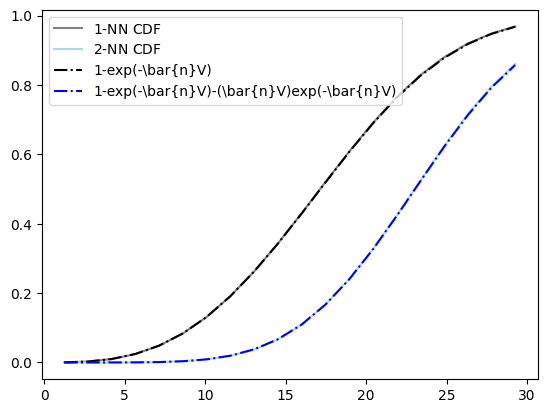

In [28]:
cdf=TracerAuto3D(boxsize=boxsize, kList=[1,2,4], BinsRad=[binrad, binrad, binrad], QueryPos=querypos, TracerPos=tracerpos, ReturnNNdist=True,Verbose=True)
analyticcdf1=1-np.exp(-nbar*(4/3)*np.pi*binrad**3)
analyticcdf2=1-np.exp(-nbar*(4/3)*np.pi*binrad**3)-(nbar*(4/3)*np.pi*binrad**3)*np.exp(-nbar*(4/3)*np.pi*binrad**3)
plt.plot(binrad, cdf[0][0], linestyle="-", color="grey", label=r"$1$-NN CDF")
plt.plot(binrad, cdf[0][1], linestyle="-", color="lightblue", label=r"$2$-NN CDF")
plt.plot(binrad, analyticcdf1, linestyle="-.", color="k", label=r"1-exp(-\bar{n}V)")
plt.plot(binrad, analyticcdf2, linestyle="-.", color="blue", label=r"1-exp(-\bar{n}V)-(\bar{n}V)exp(-\bar{n}V)")

plt.legend()

## For large-scale structure